### Fraudulent Transactions - Training a classifier with Sklearn

In this Jupyter Notebook we will be training a simple classifier using Sklearn to detect fraudulent transactions. <br/>

1. Load the dataset
2. Explore the dataset
3. Transform the dataset
4. Split the dataset
5. Train our first model
6. Evaluate our model <br/>
    a) Accuracy <br/>
    b) Precision/Recall <br/>
    c) Confusion matrix <br/>
7. Iterate
8. Persist our model
9. Export to ONNX format <br/>
10. Summary

---

#### 1. Load the data
To load the data, upload your dataset in the file explorer to the right and using <br/>
pandas to load your dataset in to a dataframe

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('data.csv')

#### 2. Explore
Use df.info to get an overview of the datatypes and size of our dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


The size of dataset is: **6,362,619** rows with a total of **11 columns** <br/>
The columns step, nameOrig and nameDest are contains textual features

We can use df.head to take a quick look the values in our dataset

In [28]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


##### 2.1 Plot our data
We can use matlibplot to explore visual patterns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74e5c94978>,
      dtype=object)

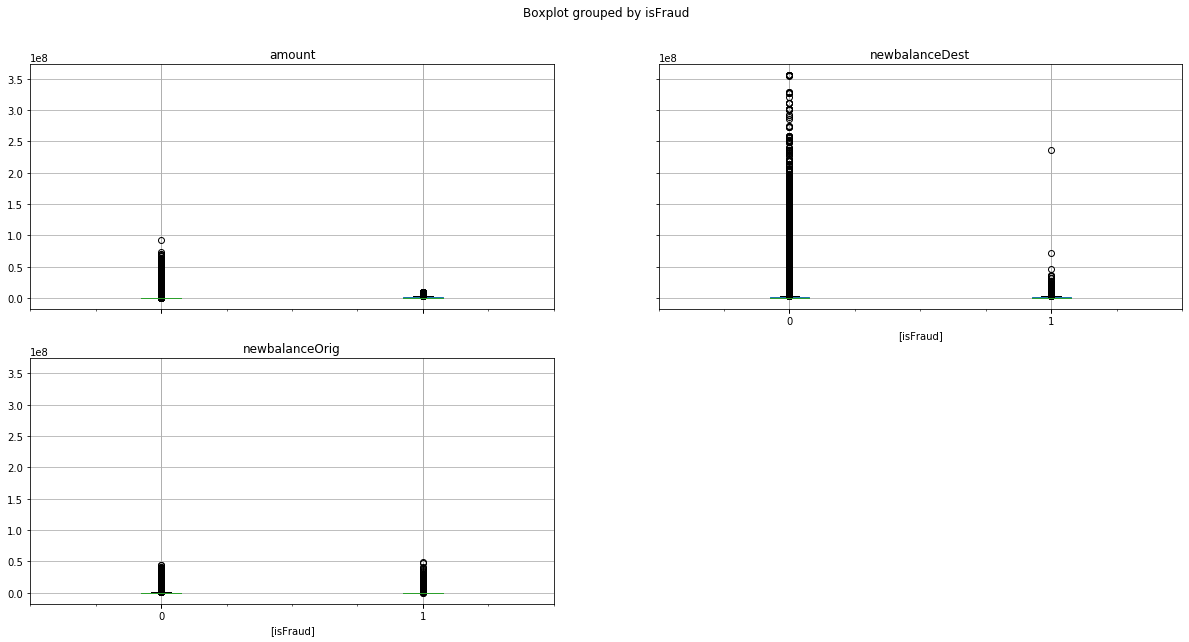

In [51]:
import matplotlib.pyplot as plt

columns_to_plot = df[['amount', 'newbalanceOrig', 'newbalanceDest', 'isFraud']] 
columns_to_plot.boxplot(figsize=(20,10), by='isFraud')

We can extract a couple of patterns from these plots.
1. Fradulent transactions appears to include smaller amounts
2. Fradulent transactions usually goes to accounts with small amounts

##### 2.2 Find missing values
We can use pandas isna (is not a number) method to determine if we have any missing values in our dataframe

In [57]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Fortunately for us we do not have any missing values to address

#### 3. Transform
Before we can start to work with our data, we need to transform it to a format an algorithm can understand<br/>

Tranforming the data may include:
- Replacing any missing values, infinity or NaN
- Transforming textual features
- Normalize the feature space

We have already determined that we do not have any missing values.

Let's start by extracting out our feature set (columns to use for predictions) and our label column

In [56]:
# Drop non-needed column
df.drop(['isFlaggedFraud'], axis=1)

#Get all columns before isFraud as features
X = df[df.columns[:9]]

#Fetch column isFraud as label
Y = df[df.columns[9:]]

##### 3.1 OneHotEncoding of type
The **nameOrig** and **nameDest** columns contain string values which we need to transform to float vectors.
But before we jump in to those columns, let look at the **type** column. Given that this column has finitive options, we can use OneHotEncoding to transform the values to binary options.

Pandas provide a very useful function for this, get_dummies.<br/> 
We can utilize this function to create new binary columns, drop the original column and concatenate the two dataframes.

In [8]:
X = pd.concat([X, pd.get_dummies(X['type'], prefix='type')], axis=1)

X.drop(['type'],axis=1, inplace=True)
X.head(10)

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0,0,1,0
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0,0,1,0
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,0,0,0,0,1
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,0,1,0,0,0
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0,0,1,0
5,1,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0,0,1,0
6,1,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0,0,1,0
7,1,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,0,1,0
8,1,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0,0,1,0
9,1,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0,1,0,0


##### 3.2 Label Encoding of nameOrig and nameDest
The nameOrig and nameDest columns contains a large number of permutations. OneHotEncoding could potentially create a very wide dataset, leading to out-of-memory exceptions, thus we can use something called label encoding instead to give each value a label.

In [9]:
from sklearn.preprocessing import LabelEncoder

categorical_feature_mask = X.dtypes==object
categorical_cols = X.columns[categorical_feature_mask].tolist()

le = LabelEncoder()

X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))
X.head(10)

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,757869,170136.00,160296.36,1662094,0.0,0.00,0,0,0,1,0
1,1,1864.28,2188998,21249.00,19384.72,1733924,0.0,0.00,0,0,0,1,0
2,1,181.00,1002156,181.00,0.00,439685,0.0,0.00,0,0,0,0,1
3,1,181.00,5828262,181.00,0.00,391696,21182.0,0.00,0,1,0,0,0
4,1,11668.14,3445981,41554.00,29885.86,828919,0.0,0.00,0,0,0,1,0
5,1,7817.71,6026525,53860.00,46042.29,2247218,0.0,0.00,0,0,0,1,0
6,1,7107.77,1805947,183195.00,176087.23,2063363,0.0,0.00,0,0,0,1,0
7,1,7861.64,2999171,176087.23,168225.59,2314008,0.0,0.00,0,0,0,1,0
8,1,4024.36,869140,2671.00,0.00,768940,0.0,0.00,0,0,0,1,0
9,1,5337.77,5407276,41720.00,36382.23,282960,41898.0,40348.79,0,0,1,0,0


#### 4. Split the data
To evaluate the performance of the model, we will need a dataset for training and one for testing

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_train.shape

(4262955, 13)

#### 5. Train our model
Our data is clean and in the correct format to be used by an algorithm.
To train our model, we can use ensemble training method with decision trees. <br/>
The random forest classifier will in our case create 100 decision trees, with a max depth of 2 and pool all estimations to a final prediction for each transaction.

In [11]:
Y_train = Y_train.values.flatten()
Y_test = Y_test.values.flatten()

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### 6. Evaluate our model
A model is useless until we know how accurate it is in making its predictions. 

##### 6.1 Accuracy
We can use the classifers score() method with the test dataset to extract the accuracy 

In [13]:
metrics = clf.score(X_test, Y_test)

print(metrics)

0.9987326549711502



Not bad, an accuracy of **99.9%**! <br/> 
However, if you recall, our dataset was highly unbalanced and if we just guessed non-fraudulent for all transactions we would also achieve this accuracy. Are there any other metrics we can use?

##### 6.2 Precision-Recall

- **Precision**: High precision means that all transactions we flagged as fraudulent actually where (no false positives)
- **Recall**: High recall means that we did not miss any fraudulent transactions (no false negatives)

There is a trade off between both, and it's not possible to achieve both. In our case, it would make sense to have a high recall as it is more important to not miss any fraudulent transactions. <br/>

Let's see what the values are for our classifier

In [14]:
from sklearn.metrics import classification_report
target_names = ['non-fraudulent', 'fraudulent']

pred = clf.predict(X_test)
print(classification_report(Y_test,pred, target_names=target_names))

                precision    recall  f1-score   support

non-fraudulent       1.00      1.00      1.00   2096999
    fraudulent       1.00      0.00      0.00      2666

     micro avg       1.00      1.00      1.00   2099665
     macro avg       1.00      0.50      0.50   2099665
  weighted avg       1.00      1.00      1.00   2099665



As the report indicates, the precision is good for both non-fraudulent and fraudulent cases.<br/> 
However, our **recall for fraudulent cases is 0**, meaning that we miss all fraudulent cases. 
Although we don't have any false positives, non of our customers fraudulent transactions are beight caught

If we look at the precision-recall curve, we see that the curve is pushed against the left, when we actually want it towards the right

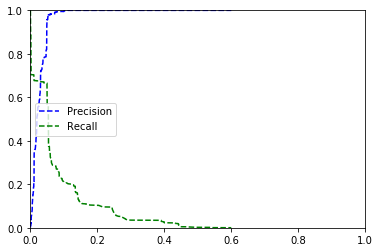

In [25]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

Y_score = clf.predict_proba(X_test)
Y_score = Y_score[:, 1]
Y_score = Y_score.flatten()

precisions, recalls, thresholds = precision_recall_curve(Y_test, Y_score)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.legend(loc="center left")
plt.ylim([0, 1])
plt.xlim([0, 1])

plt.show()

##### 6.3 Confusion matrix
To further explore the ratio between false positives, false negatives, true positives and true negatives, we can have a look at the confusion matrix.

In [67]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names =  ['non-fraudulent', 'fraudulent']


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


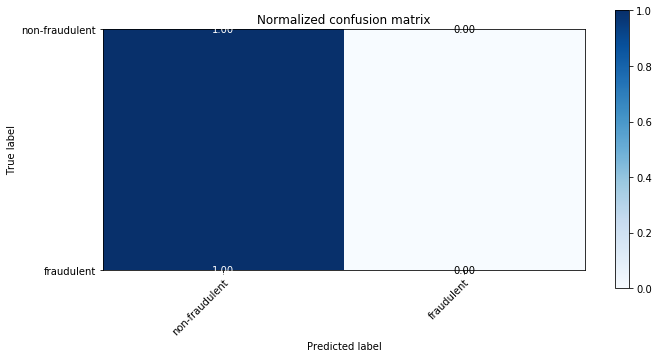

In [68]:
# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

The confusion matrix tells us that we marked all fraudulent cases as non-fraudulent, not great.

#### 7. Iterate
So our model is far from great, let's see if we can improve it. 
One of the issues we are seeing right now is that despite it's accuracy, it is missing a lot of fraudulent transactions.
A struggle we have is that our dataset is highly imbalanced. We can address this by weighing our inputs

Let's train our model again, but boosting our minority class, is fraudulent

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf_with_weights = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, class_weight="balanced")
clf_with_weights.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [17]:
metrics = clf_with_weights.score(X_test, Y_test)

print(metrics)

0.9462423767601023


Our accuarcy dropped to **94.6%**, but let's see if we can outweight that with better recall-precision

In [18]:
from sklearn.metrics import classification_report
target_names = ['non-fraudulent', 'fraudulent']

pred_with_weights = clf_with_weights.predict(X_test)
print(classification_report(Y_test, pred_with_weights, target_names=target_names))

                precision    recall  f1-score   support

non-fraudulent       1.00      0.95      0.97   2096999
    fraudulent       0.02      0.93      0.04      2666

     micro avg       0.95      0.95      0.95   2099665
     macro avg       0.51      0.94      0.51   2099665
  weighted avg       1.00      0.95      0.97   2099665



Wow! We can see that especially recall greatly increased for the fraudulent cases, meaning that we miss a lot less false negatives

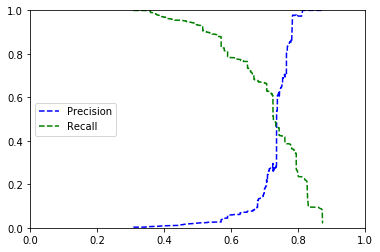

In [19]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

Y_score = clf_with_weights.predict_proba(X_test)
Y_score = Y_score[:, 1]
Y_score = Y_score.flatten()

precisions, recalls, thresholds = precision_recall_curve(Y_test, Y_score)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.legend(loc="center left")
plt.ylim([0, 1])
plt.xlim([0, 1])

plt.show()

##### Confusion matrix
Let's explore the confusion matrix for our new model

Normalized confusion matrix
[[0.95 0.05]
 [0.07 0.93]]


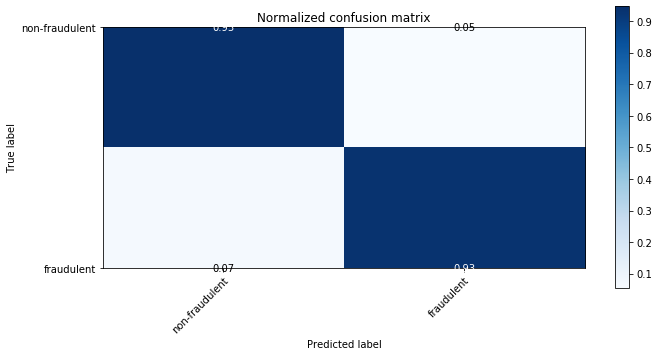

In [69]:
# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, pred_with_weights, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Much better. Although not perfect we see that only 7% of fraudulent cases are missed and marked as non-fraudulent. Similarly we mark 5% as fraudulent while they are not

#### 8. Persist our model
There are multiple ways in which we can persist our trained model. 
Let's look at using both scikit learn as well as Azure's Python SDK to do so

- Using Scikit Learn

In [23]:
from sklearn.externals import joblib
joblib.dump(value=clf_with_weights, filename="fraudulent-classifier.pkl")

['fraudulent-classifier.pkl']

- Using Azure's Python SDK

In [24]:
from azureml.core import Workspace
from azureml.core.model import Model

ws = Workspace.get(name="fraudulent", subscription_id='b70d598f-6ad7-4a83-b960-927dfe48405f', resource_group='azureml2')
model = Model.register(workspace=ws, model_path="fraudulent-classifier.pkl", model_name="fraudulent-jupyter-model")

Registering model fraudulent-jupyter-model


#### 9. ONNX Format
The Open Neural Exchange Format (ONNX) allows models trained in different libraries to be loaded and used in others.
ONNX is fully backed by Google, Facebook and Microsoft. Models trained in Python, e.g. using SciKitLearn or PyTorch can be exported to an ONNX format and imported and consumed by ML.NET

In [26]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('float_input', FloatTensorType([1, X_train.shape[1]]))]
onx = convert_sklearn(clf_with_weights, initial_types=initial_type)
with open("fraudulent-classifier-jupyter.onnx", "wb") as f:
    f.write(onx.SerializeToString())

WARNING - The maximum opset needed by this model is only 1.
WARNING - The maximum opset needed by this model is only 9.


### Summary
This Notebook has demonstrated how you can build your own classifier using Python open-source libraries such as Pandas, ScikitLearn and Numpy in a Jupyter VM in Azure Machine Learning Service.
As we can see, finding a good algorithm and fine-tunning its hyper-parameters can be complicated, but working with the notebook makes the work structured and easy to repeat